In [1]:
import torch
import utils
import networks
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
LATENT_DIM = 64
EPOCHS = 50
%matplotlib inline

In [ ]:
# GLO training
dataloader, ds = utils.get_glomnist_dataloader(64)
G = networks.Generator().to(device)
ds.z = ds.z.to(device)
optimizer = torch.optim.Adam([{'params': G.parameters()}, {'params': ds.z.requires_grad_()}], 1e-3, (0.5, 0.999))

for e in range(50):
    G.train()
    for (x, z) in dataloader:
        x = x.to(device)
        z = F.normalize(z, p=2)
        z.requires_grad_()
        out = G(z)
        loss = F.mse_loss(out, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    G.eval()
    with torch.no_grad():
        for (x, z) in dataloader:
            x = x.to(device)
            z = F.normalize(z, p=2)
            out = G(z)
            loss = F.mse_loss(out, x).item()
            torchvision.utils.save_image(out*0.5+0.5, 'glos/{}.jpg'.format(e))
            print(e, loss)
            break

torch.save(ds.z.detach().cpu, 'glo_zs.pth')
torch.save(G.state_dict(), 'glo_G.pth')

(3, 242, 242)


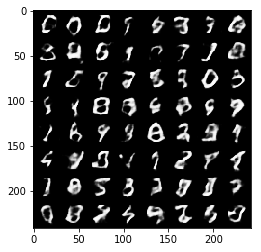

In [3]:
# Generation
G = networks.Generator().to(device)
G.load_state_dict(torch.load('glo_G.pth'))
G.eval()
with torch.no_grad():
    z = torch.randn(64, LATENT_DIM).to(device)
    z = F.normalize(z, p=2)

    out = G(z)
    out = (out * 0.5 + 0.5).cpu()
    out = torchvision.utils.make_grid(out).numpy()
    print(out.shape)

    plt.imshow(out.transpose(1, 2, 0))
    plt.show()